<a href="https://colab.research.google.com/github/yding25/Kuka_with_Sucker/blob/main/Kuka_with_a_sucker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pick-place demo
<img src="https://raw.githubusercontent.com/yding25/pic_share/master/pybullet.jpeg" height="300" />

**Background**: Kuka with a sucker completes pick-place tasks.

# Setup

In [ ]:
#@title Download URDF models {display-mode: "form"}
# !rm -rf /content/urdf_models/
!git clone https://github.com/yding25/urdf_models.git

In [ ]:
#@title Import third-party packages {display-mode: "form"}
!pip install pybullet imageio-ffmpeg
import os
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pybullet
import pybullet_data
import cv2
import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML
from google.colab.patches import cv2_imshow
from IPython.display import display
from tqdm.notebook import tqdm

In [ ]:
#@title Utils {display-mode: "form"}

class Client():
  def __init__(self):
    pybullet.connect(pybullet.DIRECT) # pybullet.GUI for local GUI.
    pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())
    pybullet.setGravity(0, 0, -9.8)
    
    # reset robot
    self.plane_id = pybullet.loadURDF("plane.urdf")
    self.robot_id = pybullet.loadURDF("kuka_iiwa/model_vr_limits.urdf", basePosition=[1.7, 0.0, 0.6], baseOrientation=[0.0, 0.0, 0.0, 1.0])
    jointPositions = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    for jointIndex in range(pybullet.getNumJoints(self.robot_id)):
        pybullet.resetJointState(self.robot_id, jointIndex, jointPositions[jointIndex])
        pybullet.setJointMotorControl2(self.robot_id, jointIndex, pybullet.POSITION_CONTROL, jointPositions[jointIndex], 0)

    # camera width and height
    self.cam_width = 480
    self.cam_height = 480

  def render_image(self):
    # camera parameters
    cam_target_pos = [1.0, 0.0, 0.5]
    cam_distance = 1.5
    cam_yaw, cam_pitch, cam_roll = -90, -90, 0
    cam_up, cam_up_axis_idx, cam_near_plane, cam_far_plane, cam_fov = [0, 0, 1], 2, 0.01, 100, 60
    cam_view_matrix = pybullet.computeViewMatrixFromYawPitchRoll(cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx)
    cam_projection_matrix = pybullet.computeProjectionMatrixFOV(cam_fov, self.cam_width*1./self.cam_height, cam_near_plane, cam_far_plane)
    znear, zfar = 0.01, 10.

    # get raw data
    _, _, color, depth, segment = pybullet.getCameraImage(
        width=self.cam_width,
        height=self.cam_height,
        viewMatrix=cam_view_matrix,
        projectionMatrix=cam_projection_matrix,
        shadow=1,
        flags=pybullet.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX,
        renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)

    # get color image.
    color_image_size = (self.cam_width, self.cam_height, 4)
    color = np.array(color, dtype=np.uint8).reshape(color_image_size)
    color = color[:, :, :3]  # remove alpha channel

    # get depth image.
    depth_image_size = (self.cam_width, self.cam_height)
    zbuffer = np.float32(depth).reshape(depth_image_size)
    depth = (zfar + znear - (2 * zbuffer - 1) * (zfar - znear))
    depth = (2 * znear * zfar) / depth

    # get segment image.
    segment = np.reshape(segment, [self.cam_width, self.cam_height]) * 1. / 255.
    return color, depth, segment

  def reset_video(self):
    video = imageio_ffmpeg.write_frames('video.mp4', (self.cam_width, self.cam_height), fps=60)
    video.send(None) # seed the video writer with a blank frame
    return video

  def render_video(self, video, image):
    video.send(np.ascontiguousarray(image))
    
  def play_video(self):
    mp4 = open('video.mp4', 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)

  def add_objects(self, utensil_name, utensil_pose):
    utensil_id = {}

    flags = pybullet.URDF_USE_INERTIA_FROM_FILE
    path = '/content/urdf_models/'

    # add table
    table_id = pybullet.loadURDF("/content/urdf_models/furniture_table_rectangle/table.urdf", basePosition=[1.0, 0.0, 0.0], baseOrientation=[0, 0, 0.7071, 0.7071])
    utensil_id['table'] = table_id

    # add objects according to utensil_name
    if 'bread plate' in utensil_name:
      utensil_id['bread plate'] = pybullet.loadURDF(path + 'utensil_plate_circle' + '/model.urdf', basePosition=utensil_pose['bread plate'][0], baseOrientation=utensil_pose['bread plate'][1], flags=flags)
    if 'butter knife' in utensil_name:
      utensil_id['butter knife'] = pybullet.loadURDF(path + 'utensil_knife' + '/model.urdf', basePosition=utensil_pose['butter knife'][0], baseOrientation=utensil_pose['butter knife'][1], flags=flags)
    if 'fork' in utensil_name:
      utensil_id['fork'] = pybullet.loadURDF(path + 'utensil_fork' + '/model.urdf', basePosition=utensil_pose['fork'][0], baseOrientation=utensil_pose['fork'][1],flags=flags)
    if 'spoon' in utensil_name:
      utensil_id['spoon'] = pybullet.loadURDF(path + 'utensil_spoon' + '/model.urdf', basePosition=utensil_pose['spoon'][0], baseOrientation=utensil_pose['spoon'][1], flags=flags)
    if 'water glass' in utensil_name:
      utensil_id['water glass'] = pybullet.loadURDF(path + 'utensil_cup_blue' + '/model.urdf', basePosition=utensil_pose['water glass'][0], baseOrientation=utensil_pose['water glass'][1], flags=flags)
    if 'wine glass' in utensil_name:
      utensil_id['wine glass'] = pybullet.loadURDF(path + 'utensil_cup_blue' + '/model.urdf', basePosition=utensil_pose['wine glass'][0], baseOrientation=utensil_pose['wine glass'][1], flags=flags)
    if 'napkin' in utensil_name:
      utensil_id['napkin'] = pybullet.loadURDF(path + 'utensil_cup_green' + '/model.urdf', basePosition=utensil_pose['napkin'][0], baseOrientation=utensil_pose['napkin'][1], flags=flags)
    if 'dinner knife' in utensil_name:
      utensil_id['dinner knife'] = pybullet.loadURDF(path + 'utensil_knife' + '/model.urdf', basePosition=utensil_pose['dinner knife'][0], baseOrientation=utensil_pose['dinner knife'][1], flags=flags)
    if 'dinner plate' in utensil_name:
      utensil_id['dinner plate'] = pybullet.loadURDF(path + 'utensil_plate' + '/model.urdf', basePosition=utensil_pose['dinner plate'][0], baseOrientation=utensil_pose['dinner plate'][1], flags=flags)
    if 'test' in utensil_name:
      utensil_id['test'] = pybullet.loadURDF(path + 'utensil_fork' + '/model.urdf', basePosition=utensil_pose['test'][0], baseOrientation=utensil_pose['test'][1], flags=flags)
    return utensil_id
    
  def get_bounding_box(self, obj_id):
    (min_x, min_y, min_z), (max_x, max_y, max_z)= pybullet.getAABB(obj_id)
    return [min_x, min_y, min_z], [max_x, max_y, max_z]

  def home_joints(self):
    jointPositions = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    for jointIndex in range(pybullet.getNumJoints(self.robot_id)):
        pybullet.resetJointState(self.robot_id, jointIndex, jointPositions[jointIndex])
        pybullet.setJointMotorControl2(self.robot_id, jointIndex, pybullet.POSITION_CONTROL, jointPositions[jointIndex], 0)

  def pick_place(self, object_id, object_position_init, object_position_end, video):
    gripper_id = None
    num_joints = pybullet.getNumJoints(self.robot_id)
    end_effector_index = 6
    # target_position = [0.9, -0.6, 0.65]
    target_position = [object_position_init[0], object_position_init[1], object_position_init[2] + 0.1]

    for step in tqdm(range(900)):
      if step % 4 == 0: # PyBullet default simulation time step is 240fps, but we want to record video at 60fps.
        rgb, depth, mask = self.render_image()
        self.render_video(video, np.ascontiguousarray(rgb))

      target_orientation = pybullet.getQuaternionFromEuler([0, 1.01*math.pi, 0])
      gripper_status = {'ungrasp': 0, 'grasp': 1}
      gripper_value = gripper_status['ungrasp']
      if step >= 150 and step < 250:
          target_position = [object_position_init[0], object_position_init[1], object_position_init[2] + 0.1] # grab object
          gripper_value = gripper_status['grasp']
      elif step >= 250 and step < 400:
          # target_position = [0.85, -0.2, 0.7 + 0.2*(step-250)/150.] # move up after picking object
          target_position = [object_position_init[0], object_position_init[1], object_position_init[2] + 0.3]
          gripper_value = gripper_status['grasp']
      elif step >= 400 and step < 600:
          # target_position = [0.85, -0.2 + 0.4*(step-400)/200., 0.9] # move to target position
          target_position = [object_position_init[0] + (object_position_end[0] - object_position_init[0]) * (step-400)/200, object_position_init[1] + (object_position_end[1] - object_position_init[1]) * (step-400)/200, object_position_init[2] + 0.3]
          gripper_value = gripper_status['grasp']
      elif step >= 600 and step < 700:
          target_position = [object_position_end[0], object_position_end[1], object_position_end[2] + 0.3] # stop at target position
          gripper_value = gripper_status['grasp']
      elif step >= 700:
          target_position = [object_position_end[0], object_position_end[1], object_position_end[2] + 0.3] # drop object
          gripper_value = gripper_status['ungrasp']

      joint_poses = pybullet.calculateInverseKinematics(self.robot_id, end_effector_index, target_position, target_orientation)
      for joint_index in range(num_joints):
          pybullet.setJointMotorControl2(bodyIndex = self.robot_id, jointIndex = joint_index, controlMode = pybullet.POSITION_CONTROL, targetPosition = joint_poses[joint_index])

      if gripper_value == 0 and gripper_id != None:
          pybullet.removeConstraint(gripper_id)
          gripper_id = None
      if gripper_value == 1 and gripper_id == None:
          cube_orn = pybullet.getQuaternionFromEuler([0, math.pi, 0])
          gripper_id = pybullet.createConstraint(self.robot_id, end_effector_index, object_id, -1, pybullet.JOINT_FIXED, [0, 0, 0], [0, 0, 0.05], [0, 0, 0], childFrameOrientation=cube_orn)

      pybullet.stepSimulation()

  def disconnect(self):
    pybullet.disconnect()

# Initialize Environment

In [ ]:
#@title Initialize env {display-mode: "form"}
demo = Client()

In [ ]:
#@title select object {display-mode: "form", vertical-output: true }

has_bread_plate = True #@param {type:"boolean"}
has_butter_knife = False #@param {type:"boolean"}
has_fork = False #@param {type:"boolean"}
has_spoon = False #@param {type:"boolean"}
has_water_glass = False #@param {type:"boolean"}
has_wine_glass = False #@param {type:"boolean"}
has_napkin = False #@param {type:"boolean"}
has_dinner_knife = False #@param {type:"boolean"}
has_dinner_plate = False #@param {type:"boolean"}
# has_test = True #@param {type:"boolean"}

utensil_name = [] # save existing utensils
utensil_pose = {} # save pose of existing utensils

# bread plate
if has_bread_plate:
  utensil_name.append('bread plate')
  utensil_pose['bread plate'] = [[1.4, -0.65, 0.65], [0, 0, 0, 1]]
# butter knife
if has_butter_knife:
  utensil_name.append('butter knife')
  utensil_pose['butter knife'] = [[0.85, -0.2, 0.65], [0, 0, 0, 1]]
# fork
if has_fork:
  utensil_name.append('fork')
  utensil_pose['fork'] = [[0.85, -0.2, 0.65], [0, 0, 0, 1]]
# spoon
if has_spoon:
  utensil_name.append('spoon')
  utensil_pose['spoon'] = [[0.85, -0.2, 0.65], [0, 0, 0, 1]] 
# water glass
if has_water_glass:
  utensil_name.append('water glass')
  utensil_pose['water glass'] = [[0.85, -0.2, 0.65], [0, 0, 0, 1]]
# wine glass
if has_wine_glass:
  utensil_name.append('wine glass')
  utensil_pose['wine glass'] = [[0.85, -0.2, 0.65], [0, 0, 0, 1]]
# napkin
if has_napkin:
  utensil_name.append('napkin')
  utensil_pose['napkin'] = [[0.85, -0.2, 0.65], [0, 0, 0, 1]]
# dinner knife
if has_dinner_knife:
  utensil_name.append('dinner knife')
  utensil_pose['dinner knife'] = [[0.85, -0.2, 0.65], [0, 0, 0, 1]]
# plate
if has_dinner_plate:
  utensil_name.append('dinner plate')
  utensil_pose['dinner plate'] = [[0.85, -0.2, 0.65], [0, 0, 0, -1]]
# test
# if has_test:
#   utensil_name.append('test')
#   utensil_pose['test'] = [[0.85, -0.2, 0.65], [0, 0, 0, -1]]

print('existing utensil:\n{}'.format(utensil_name))
print('their pose:\n{}'.format(utensil_pose))

existing utensil:
['bread plate']
their pose:
{'bread plate': [[1.4, -0.65, 0.65], [0, 0, 0, 1]]}


In [ ]:
#@title add objects {display-mode: "form", vertical-output: true }
utensil_id = demo.add_objects(utensil_name, utensil_pose)
print('utensil_id:{}'.format(utensil_id))

utensil_id:{'table': 2, 'bread plate': 3}


In [ ]:
#@title get AABB info {display-mode: "form", vertical-output: true }
for key in utensil_id:
  print('object: {}, and its AABB:'.format(key))
  [min_x, min_y, min_z], [max_x, max_y, max_z] = demo.get_bounding_box(utensil_id[key])
  print('min_x:{} min_y:{} min_z:{}'.format(min_x, min_y, min_z))
  print('max_x:{} max_y:{} max_z:{}\n'.format(max_x, max_y, max_z))

'''
        y=0.75       y=-0.75
 x=1.5  —— —— —— —— ——
       |               |
       |               |
       |               |
       |               |
 x=0.5  —— —— —— —— ——

'''

object: table, and its AABB:
min_x:0.4989999999999998 min_y:-0.7510000000000002 min_z:0.574
max_x:1.5010000000000003 max_y:0.7510000000000002 max_z:0.626

object: bread plate, and its AABB:
min_x:1.3199559972882269 min_y:-0.7303620009422302 min_z:0.6346969996839762
max_x:1.479603002846241 max_y:-0.5696109981536865 max_z:0.6650149999856949



'\n        y=0.75       y=-0.75\n x=1.5  —— —— —— —— ——\n       |               |\n       |               |\n       |               |\n       |               |\n x=0.5  —— —— —— —— ——\n\n'

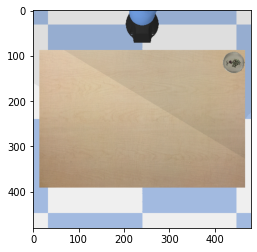

In [ ]:
#@title display initial environment {display-mode: "form", vertical-output: true }
rgb, depth, mask = demo.render_image()
plt.imshow(rgb)

In [ ]:
#@title start recording {display-mode: "form", vertical-output: true }
video = demo.reset_video()

In [ ]:
#@title pick-place utensils {display-mode: "form", vertical-output: true }
object_id = utensil_id['bread plate']
object_position_init = utensil_pose['bread plate'][0]
#@markdown please enter object's goal position, x=[0.5, 1.5], y=[-0.75, 0.75\]
position_x = 1.0 #@param {type:"number"}
position_y = 0.0 #@param {type:"number"}
object_position_end = [position_x, position_y, 0.8]
demo.pick_place(object_id, object_position_init, object_position_end, video)

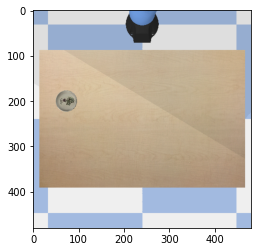

In [ ]:
#@title display final environment {display-mode: "form", vertical-output: true }
demo.home_joints()
rgb, depth, mask = demo.render_image()
demo.render_video(video, np.ascontiguousarray(rgb))
plt.imshow(rgb) # show the last image

In [ ]:
#@title play video {display-mode: "form", vertical-output: true }
video.close()
demo.play_video()

In [ ]:
#@title disconnect pybullet {display-mode: "form", vertical-output: true }
demo.disconnect()